# Landau-Lifshitz-Bloch simulations

In [33]:
from IPython.display import display

In [34]:
import udkm1Dsim as ud
u = ud.u  # import the pint unit registry from udkm1Dsim
import scipy.constants as constants
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline
u.setup_matplotlib()  # use matplotlib with pint units

In [35]:
Ni = ud.Atom('Ni', mag_amplitude=1, mag_gamma=90*u.deg, mag_phi=0*u.deg)
Si = ud.Atom('Si')

In [36]:
prop_Ni = {}


# Two-temperture model
prop_Ni['heat_capacity'] = ['lambda T: 0.12*T', 442*u.J/(u.kg * u.K)] 
# 0.08*T (Zahn 2021, 10.1103/PhysRevResearch.3.023032)
# el: 10.1016/S0301-0104(99)00330-4, ph: 10.1016/0022-3697(81)90174-8
prop_Ni['therm_cond'] = ['lambda T: (81.4)*(T[0]/T[1])', 9.6] # 10.1016/S0301-0104(99)00330-4
prop_Ni['sub_system_coupling'] = ['lambda T:3.6e17*(T[1]-T[0])', 
         'lambda T:3.6e17*(T[0]-T[1])']  # 10.1103/PhysRevB.77.075133
prop_Ni['lin_therm_exp'] = ['lambda T: 0.0041e-6*T', 20.2e-6]

# Elastic parameters
prop_Ni['elastic_c11'] = 327e9*u.kg/(u.m*u.s**2)  # 10.1063/1.1702218: c11=253, c12=152, c44=124
prop_Ni['elastic_c12'] = 128e9*u.kg/(u.m*u.s**2)  # 10.1063/1.1702218: c11=253, c12=152, c44=124
prop_Ni['elastic_c13'] = 103e9*u.kg/(u.m*u.s**2)  # 10.1063/1.1702218: c11=253, c12=152, c44=124
prop_Ni['elastic_c22'] = 327e9*u.kg/(u.m*u.s**2)  # 10.1063/1.1702218: c11=253, c12=152, c44=124
prop_Ni['elastic_c23'] = 103e9*u.kg/(u.m*u.s**2)  # 10.1063/1.1702218: c11=253, c12=152, c44=124
prop_Ni['elastic_c33'] = 351e9*u.kg/(u.m*u.s**2)  # 10.1063/1.1702218: c11=253, c12=152, c44=124
prop_Ni['sound_vel'] = 6.3*u.nm/u.ps  # calculated -- np.sqrt(c33/density)

# Optical parameters
prop_Ni['opt_ref_index'] = 2.9174+3.3545j

prop_Ni['eff_spin'] = 0.5
prop_Ni['curie_temp'] = 630*u.K
prop_Ni['lamda'] = 0.08
prop_Ni['mag_moment'] = 0.393*u.bohr_magneton
prop_Ni['aniso_exponent'] = 3
prop_Ni['anisotropy'] = [-500, 0., 7.72e4]*u.J/u.m**3
prop_Ni['exch_stiffness'] = [15e-15, 15e-15, 15e-15]*u.J/u.m
prop_Ni['mag_saturation'] = 4e5*u.J/u.T/u.m**3
660
# build the layer
layer_Ni = ud.AmorphousLayer('Ni', 'Ni amorphous', thickness=1*u.nm,
                             density=7000*u.kg/u.m**3, atom=Ni, **prop_Ni)

Number of subsystems changed from 1 to 2.


In [37]:
# this is the non-magnetic substrate
prop_Si = {}
prop_Si['heat_capacity'] = [100*u.J/u.kg/u.K, 603*u.J/u.kg/u.K]
prop_Si['therm_cond'] = [0, 100*u.W/(u.m*u.K)]

prop_Si['sub_system_coupling'] = [0, 0]

prop_Si['lin_therm_exp'] = [0, 2.6e-6]
prop_Si['sound_vel'] = 8.433*u.nm/u.ps
prop_Si['opt_ref_index'] = 3.6941+0.0065435j

layer_Si = ud.AmorphousLayer('Si', "Si amorphous", thickness=1*u.nm, density=2336*u.kg/u.m**3,
                             atom=Si, **prop_Si)

Number of subsystems changed from 1 to 2.


In [38]:
S = ud.Structure('Ni 20')

S.add_sub_structure(layer_Ni, 20)
S.add_sub_structure(layer_Si, 200)

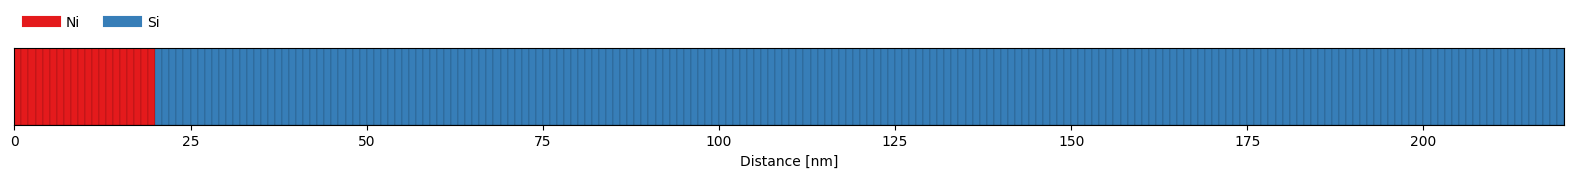

In [39]:
S.visualize()

## Initialize Heat and the Excitation

In [40]:
h = ud.Heat(S, True)

h.save_data = False
h.disp_messages = True

In [41]:
h.excitation = {'fluence': [1.6]*u.mJ/u.cm**2,
                'delay_pump':  [0]*u.ps,
                'pulse_width':  [0.15]*u.ps,
                'multilayer_absorption': True,
                'wavelength': 800*u.nm,
                'theta': 90*u.deg}
# temporal and spatial grid
delays = np.r_[-4000:-10:0.1, -10:10:0.05, 10:600:0.5]*u.ps
_, _, distances = S.get_distances_of_layers()

## Calculate Heat Diffusion for 2-Temperature Model

In [42]:
# enable heat diffusion
h.heat_diffusion = True
# set the boundary conditions
h.boundary_conditions = {'top_type': 'isolator', 'bottom_type': 'isolator'}
# The resulting temperature profile is calculated in one line:

temp_map, delta_temp = h.get_temp_map(delays, 300)

Surface incidence fluence scaled by factor 1.0000 due to incidence angle theta=90.00 deg
Calculating _heat_diffusion_ for excitation 1:1 ...
Absorption profile is calculated by multilayer formalism.
Total reflectivity of 54.6 % and transmission of 22.8 %.


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_ with 1 excitation(s): 4.642491 s
Calculating _heat_diffusion_ without excitation...


0it [00:00, ?it/s]

Elapsed time for _heat_diffusion_: 4.667391 s
Elapsed time for _temp_map_: 10.353932 s


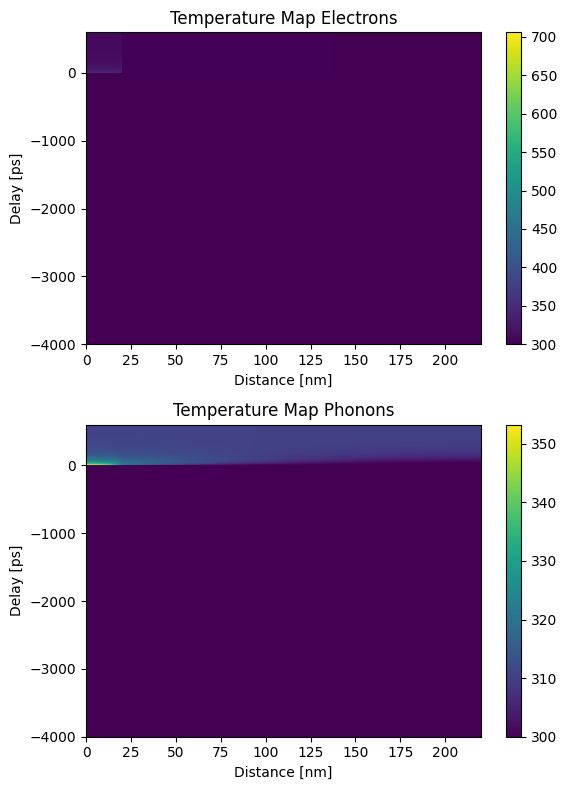

In [43]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map[:, :, 0],
               shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map Electrons')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map[:, :, 1],
               shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map Phonons')

plt.tight_layout()
plt.show()

## Strain simulations

Calculating linear thermal expansion ...
Calculating coherent dynamics with ODE solver ...


0it [00:00, ?it/s]

Elapsed time for _strain_map_: 2.661955 s


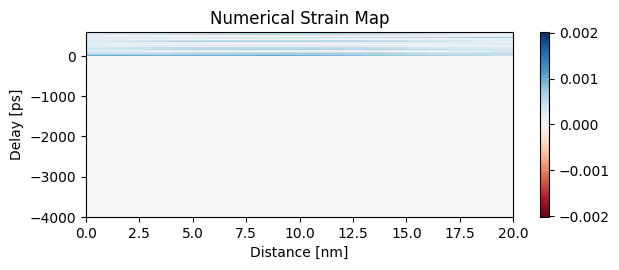

In [44]:
pnum = ud.PhononNum(S, True)
pnum.save_data = False
pnum.disp_messages = True


strain_map = pnum.get_strain_map(delays, temp_map, delta_temp)


plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude,
               strain_map, cmap='RdBu', vmin=-np.max(strain_map),
               vmax=np.max(strain_map), shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Numerical Strain Map')
plt.xlim(0,20)
plt.tight_layout()
plt.show()

## Landau-Lifshitz-Bloch Simulations

The `LLB` class requires a `Structure` object and a boolean `force_recalc` in order to overwrite previous simulation results.

These results are saved in the `cache_dir` when `save_data` is enabled.
Printing simulation messages can be en-/disabled using `disp_messages` and progress bars can be enabled using the boolean switch `progress_bar`.

In [45]:
llb = ud.LLB(S, True)

llb.save_data = False
llb.disp_messages = True

print(llb)

Landau-Lifshitz-Bloch Magnetization Dynamics simulation properties:

Magnetization simulation properties:

This is the current structure for the simulations:

Structure properties:

Name   : Ni 20
Thickness : 220.0000 nanometer
Roughness : 0.0000 nanometer
----
20 times Ni amorphous: 20.0000 nanometer
200 times Si amorphous: 200.0000 nanometer
----
no substrate


Display properties:

================  =======
       parameter  value
================  =======
    force recalc  True
 cache directory  ./
display messages  True
       save data  False
    progress bar  True
================  =======


### Brillouin Function

Internally, the LLB calculates a mean-field magnetization map for the according electron temperatures
$T_e$ at for every layer and for every time step. This is done by solving the *Brillouin* function of each
layer and then mapping the result onto the according spatio-temporal grid, as given by the `temp_map`.

In [46]:
mean_field_mag_map = llb.get_mean_field_mag_map(temp_map[:, :, 0])

Calculating _mean_field_magnetization_map_ ...
Elapsed time for _mean_field_magnetization_map_: 4.001358 s


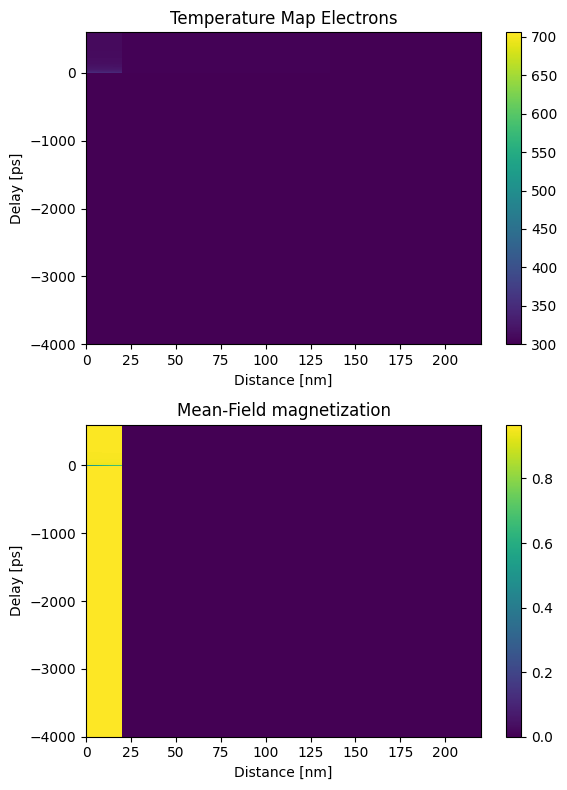

In [47]:
plt.figure(figsize=[6, 8])

plt.subplot(2, 1, 1)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map[:, :, 0],
               shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map Electrons')

plt.subplot(2, 1, 2)

plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, mean_field_mag_map, shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Mean-Field magnetization')

plt.tight_layout()

plt.show()

## Field contributions
we only consider the following contributions to the effective Field $H_{\text{eff}}$

\begin{align*}
    	\textbf{H}_{\text{eff}} &= \textbf{H}_{\text{ext}} - H_{\text{sat}} m_{\text{z}} \textbf{e}_z + H_{\text{uni}} m_{\text{x}} \textbf{e}_x + H_{\text{me}} m_{\text{z}} \textbf{e}_{z} + \mathbf{H}_\mathrm{ex}
      + \mathbf{H}_\mathrm{th}
\end{align*}

Where 

\begin{align*}
    	H_{\text{sat}} = \frac{2 K_z}{M_s} \left(\mathbf{m} \cdot \hat{e}_z\right) \hat{e}_z = 386 \, \text{mT}\\
      H_{\text{uni}} = \frac{2 K_x}{M_s} \left(\mathbf{m} \cdot \hat{e}_x\right) \hat{e}_x = 12.5 \, \text{mT}\\
      H_{\text{me}} = \frac{K_{\text{me}} \eta_z}{M_s} \left(\mathbf{m} \cdot \hat{e}_z\right) \hat{e}_z = 40.5 \, \frac{\text{mT}}{\text{Promille}} \\
      \mathbf{H}_\mathrm{ex} = \mathbf{H}_\mathrm{ex} = \frac{2 A}{M_s^2} \nabla^2 \mathbf{m}\\
\end{align*}

For $T$ smaller $T_C$
\begin{align*}
      \mathbf{H}_\mathrm{th} = \frac{1}{2 \chi_\parallel} \left( 1 - \frac{m^2}{m_\mathrm{eq}^2} \right) \mathbf{m} 
\end{align*}

For $T$ larger or equal $T_C$
\begin{align*}
      \mathbf{H}_\mathrm{th} = -\frac{1}{\chi_\parallel} \left( 1 + \frac{3}{5} \frac{T_\mathrm{C}}{T - T_\mathrm{C}} m^2 \right) \mathbf{m}
\end{align*}

Here we use $\textbf{H}_{\text{ext}} = 0.37$ mT.

## Rotation series without magnetoelastic coupling

For this simulation $\eta_z=0$


In [ ]:
phis = np.linspace(0, np.pi/2,10)

H_amp = 0.37
ind_trim = np.where(delays>-15*u.ps)
m_array = np.zeros((len(phis),len(delays)))

init_mag = np.array([1.0, (0.*u.deg).to('rad').magnitude, (0*u.deg).to('rad').magnitude])

for i, phi in enumerate(phis):
    print(phi)
    magnetization_map = llb.get_magnetization_map(delays, temp_map=temp_map, strain_map= np.zeros_like(temp_map[:,:,0]), init_mag=init_mag,
                                            H_ext=np.array([H_amp*np.sin(phi), 0, H_amp*np.cos(phi)]))
    magnetization_map_xyz = ud.helpers.convert_polar_to_cartesian(magnetization_map)
    m_array[i,:] = np.mean(magnetization_map_xyz[:, 0:20, 2], axis=1)
    print(m_array[i])
    

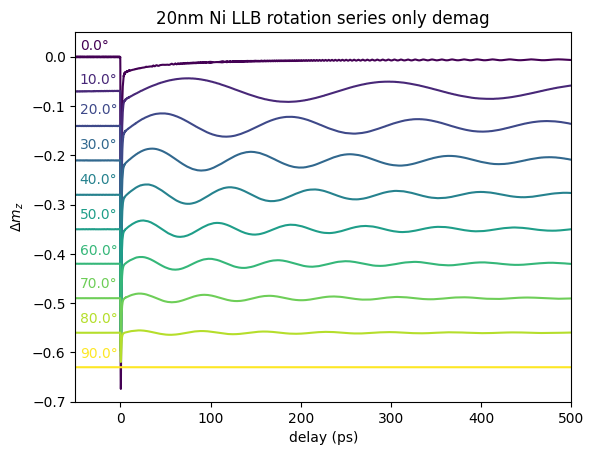

In [49]:
# Create a figure and axis
fig, ax = plt.subplots()

# Generate a colormap
cmap = plt.get_cmap("viridis")  # You can change the colormap to your preference
norm = plt.Normalize(vmin=np.min(phis), vmax=np.max(phis))  # Normalize based on 'phis'

# Plot lines for each angle in 'phis'
for i in range(len(phis)):
    color = cmap(norm(phis[i]))  # Get the color from the colormap
    ax.plot(delays, m_array[i, :] - m_array[i, ind_trim[0][0]] - 0.07 * i, color=color)

# Set limits for the plot
ax.set_xlim(-50, 500)
ax.set_ylim(-0.7, 0.05)
ax.set_xlabel("delay (ps)")
ax.set_ylabel(r"$\Delta m_z$")
ax.set_title("20nm Ni LLB rotation series only demag")

# Add annotations for the angles
for i in range(len(phis)):
    ax.annotate(f'{np.rad2deg(phis[i]):.1f}°', xy=(-10, m_array[i, -1] - m_array[i, ind_trim[0][0]] - 0.07 * i),
                xytext=(-45, m_array[i, -1] - m_array[i, ind_trim[0][0]] - 0.07 * i+0.02),
                color=cmap(norm(phis[i])), fontsize=10)

plt.savefig("LLB_only_demag.png", dpi = 250)
plt.show()

## Rotation series with magnetoelastic coupling

In [ ]:
phis = np.linspace(0, np.pi/2,10)

ind_trim = np.where(delays>-15*u.ps)
m_array = np.zeros((len(phis),len(delays)))



for i, phi in enumerate(phis):
    print(phi)
    magnetization_map = llb.get_magnetization_map(delays, temp_map=temp_map, strain_map=strain_map, init_mag=init_mag,
                                            H_ext=np.array([H_amp*np.sin(phi), 0, H_amp*np.cos(phi)]))
    magnetization_map_xyz = ud.helpers.convert_polar_to_cartesian(magnetization_map)
    m_array[i,:] = np.mean(magnetization_map_xyz[:, 0:20, 2], axis=1)
    print(m_array[i])

In [51]:


np.max(strain_map)*1000
a = llb.calc_magnetoelastic_field(magnetization_map , np.max(strain_map)*1000, [0,0,16000]*u.J*u.m**(-3), prop_Ni['mag_saturation'] )
np.min(a)






np.float64(-0.24088089848349994)

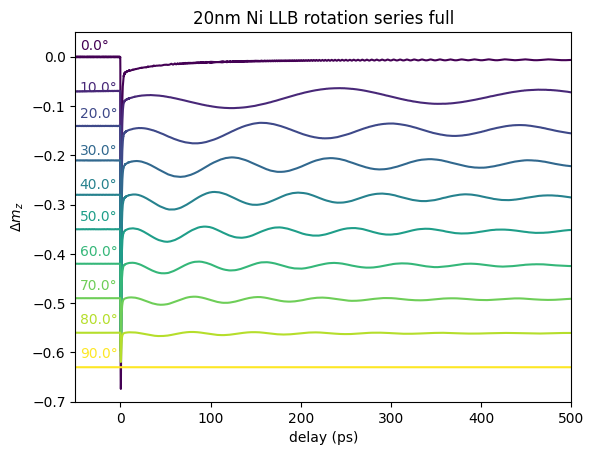

In [52]:
# Create a figure and axis
fig, ax = plt.subplots()

# Generate a colormap
cmap = plt.get_cmap("viridis")  # You can change the colormap to your preference
norm = plt.Normalize(vmin=np.min(phis), vmax=np.max(phis))  # Normalize based on 'phis'

# Plot lines for each angle in 'phis'
for i in range(len(phis)):
    color = cmap(norm(phis[i]))  # Get the color from the colormap
    ax.plot(delays, m_array[i, :] - m_array[i, ind_trim[0][0]] - 0.07 * i, color=color)

# Set limits for the plot
ax.set_xlim(-50, 500)
ax.set_ylim(-0.7, 0.05)
ax.set_xlabel("delay (ps)")
ax.set_ylabel(r"$\Delta m_z$")
ax.set_title("20nm Ni LLB rotation series full")

# Add annotations for the angles
for i in range(len(phis)):
    ax.annotate(f'{np.rad2deg(phis[i]):.1f}°', xy=(-10, m_array[i, -1] - m_array[i, ind_trim[0][0]] - 0.07 * i),
                xytext=(-45, m_array[i, -1] - m_array[i, ind_trim[0][0]] - 0.07 * i+0.02),
                color=cmap(norm(phis[i])), fontsize=10)

plt.savefig("LLB_full.png", dpi = 250)
plt.show()